In [13]:
import pickle
import random
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

import tensorflow as tf

## 1. Load dataset

In [2]:
fileObject = open('../pickles/svhn_seq','r')  
svhn_seq = pickle.load(fileObject)

In [3]:
extra_dataset = svhn_seq["extra_dataset"] 
extra_labels =  svhn_seq["extra_labels"]
extra_images =  svhn_seq["extra_images"]
extra_metadata =  svhn_seq["extra_metadata"]

## 2. Randomly select 5 pictures from extra set to get predictions for:

In [4]:
rand_list = random.sample(range(1, extra_dataset.shape[0]), 5)

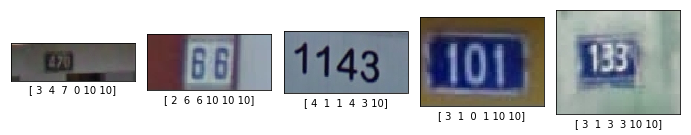

In [5]:
img_name = extra_images[rand_list]
images = [[]]*len(rand_list)

for i in range(len(images)):
    images[i] = Image.open('../data/SVHN_data/extra/'+ img_name[i])


fig, axes = plt.subplots(1,5,figsize=(12,6))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

for i, ax in enumerate(axes.flat):
    ax.imshow(images[i])
    ax.set_xticks([])
    ax.set_yticks([])
    xlabel=extra_labels[rand_list[i]]
    ax.set_xlabel(xlabel)
    
plt.savefig('../images/svhn_sample_pred.png')

## 3. Show pictures after transormation

### 3.1. Transformation procedure on example of one picture:

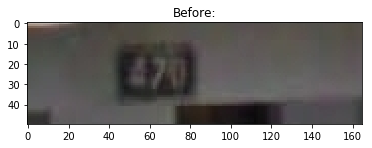

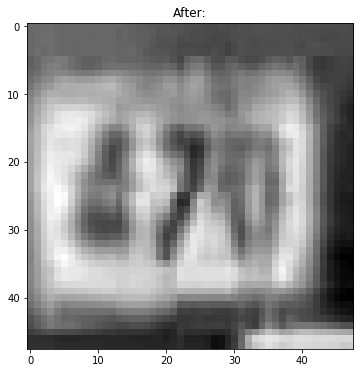

In [19]:
IMAGE_SIZE = 48
NUM_CHANNELS = 1

i = rand_list[0]
img_name =  extra_images[i]
lable = extra_labels[i]
left = extra_metadata[i][0][0:lable[0]]
top = extra_metadata[i][1][0:lable[0]]
right = extra_metadata[i][2][0:lable[0]]
bottom = extra_metadata[i][3][0:lable[0]]
width = [a_i - b_i for a_i, b_i in zip(right, left)]
height = [a_i - b_i for a_i, b_i in zip(bottom, top)]

img_min_top = np.amin(top)
img_min_left = np.amin(left)
img_height = np.amax(top) + height[np.argmax(top)] - img_min_top
img_width = np.amax(left) + width[np.argmax(left)] - img_min_left

image = Image.open("../data/SVHN_data/extra/"+ img_name)

img_left = np.floor(img_min_left - 0.1 * img_width)
img_top = np.floor(img_min_top - 0.1 * img_height)
img_right = np.amin([np.ceil(img_left + 1.2 * img_width), image.size[0]])
img_bottom = np.amin([np.ceil(img_top + 1.2 * img_height), image.size[1]]) 

image = image.crop((img_left, img_top, img_right, img_bottom)).\
resize([IMAGE_SIZE, IMAGE_SIZE], Image.ANTIALIAS)
              
        
image = np.dot(np.array(image, dtype='float32'), [[0.2989],[0.5870],[0.1140]]) 
mean = np.mean(image, dtype='float32')
std = np.std(image, dtype='float32', ddof=1)
if std < 0.0001: 
    std = 1.0
image = (image - mean) / std
image = image.reshape((IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS)).astype(np.float32)

fig, ax = plt.subplots(figsize=(6, 6))
plt.imshow(Image.open("../data/SVHN_data/extra/"+ img_name))
plt.title("Before:")

fig, ax = plt.subplots(figsize=(6, 6))
plt.imshow(image.reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='binary')
plt.title("After:")


### 3.2. Results:

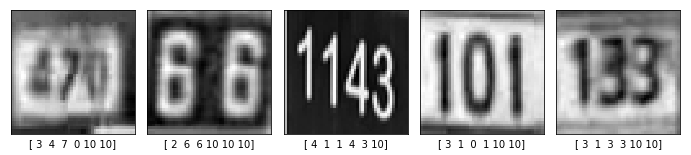

In [6]:
images = extra_dataset[rand_list,:,:,:]

fig, axes = plt.subplots(1,5,figsize=(12,6))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

for i, ax in enumerate(axes.flat):
    ax.imshow(images[i].reshape(48, 48), cmap='binary')
    ax.set_xticks([])
    ax.set_yticks([])
    xlabel=extra_labels[rand_list[i]]
    ax.set_xlabel(xlabel)
    
plt.savefig('../images/svhn_sample_transform_pred.png')

## 4. Restore model and make predictions

In [7]:
IMAGE_SIZE = 48
NUM_CHANNELS = 1
NUM_LABELS = 11

N=6

BATCH_SIZE = len(rand_list)
FILTER_SIZE = 5

NUM_FILTERS_1 = 16
NUM_FILTERS_2 = 32
NUM_FILTERS_3 = 64
NUM_FILTERS_4 = 128

NUM_NEURONS_1 = 1024
NUM_NEURONS_2 = 512

keep_prob = 0.8

tf_test_dataset = tf.placeholder(tf.float32, shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS))

## 1st convolutional layer
conv1_weights = tf.get_variable("conv1_w", shape=[FILTER_SIZE, FILTER_SIZE, NUM_CHANNELS, NUM_FILTERS_1],\
                                                initializer=tf.contrib.layers.xavier_initializer_conv2d())
conv1_biases = tf.Variable(tf.zeros([NUM_FILTERS_1]), name = "conv1_b")

## 2nd convolutional layer
conv2_weights = tf.get_variable("conv2_w", shape=[FILTER_SIZE, FILTER_SIZE, NUM_FILTERS_1, NUM_FILTERS_2],\
                                                initializer=tf.contrib.layers.xavier_initializer_conv2d())
conv2_biases = tf.Variable(tf.constant(1.0, shape=[NUM_FILTERS_2]), name = "conv2_b")
  
## 3rd convolutional layer
conv3_weights = tf.get_variable("conv3_w", shape=[FILTER_SIZE, FILTER_SIZE, NUM_FILTERS_2, NUM_FILTERS_3],\
                                                initializer=tf.contrib.layers.xavier_initializer_conv2d())
conv3_biases = tf.Variable(tf.constant(1.0, shape=[NUM_FILTERS_3]), name = "conv3_b")

## 4th convolutional layer
conv4_weights = tf.get_variable("conv4_w", shape=[FILTER_SIZE, FILTER_SIZE, NUM_FILTERS_3, NUM_FILTERS_4],\
                                                initializer=tf.contrib.layers.xavier_initializer_conv2d())
conv4_biases = tf.Variable(tf.constant(1.0, shape=[NUM_FILTERS_4]), name = "conv4_b")


## fully connected layers:
fc_weights = tf.get_variable("fc_w", shape=[IMAGE_SIZE // 16 * IMAGE_SIZE // 16 * NUM_FILTERS_4, NUM_NEURONS_1],\
                                              initializer=tf.contrib.layers.xavier_initializer())
fc_biases = tf.Variable(tf.constant(1.0, shape=[NUM_NEURONS_1]), name="fc_b")

fc1_weights = tf.get_variable("fc1_w", shape=[NUM_NEURONS_1, NUM_NEURONS_2],\
                                              initializer=tf.contrib.layers.xavier_initializer())
fc1_biases = tf.Variable(tf.constant(1.0, shape=[NUM_NEURONS_2]), name="fc1_b")


fc2_weights_L = tf.get_variable("fc2_Lw", shape=[NUM_NEURONS_2, N],\
                                initializer=tf.contrib.layers.xavier_initializer())
fc2_biases_L = tf.Variable(tf.constant(1.0, shape=[N]), name="fc2_Lb")

fc2_weights_1 = tf.get_variable("fc2_1w", shape=[NUM_NEURONS_2, NUM_LABELS],\
                                initializer=tf.contrib.layers.xavier_initializer())                                                
fc2_biases_1 = tf.Variable(tf.constant(1.0, shape=[NUM_LABELS]), name="fc2_1b")
  
fc2_weights_2 = tf.get_variable("fc2_2w", shape=[NUM_NEURONS_2, NUM_LABELS],\
                                initializer=tf.contrib.layers.xavier_initializer())    
fc2_biases_2 = tf.Variable(tf.constant(1.0, shape=[NUM_LABELS]), name="fc2_2b")

fc2_weights_3 = tf.get_variable("fc2_3w", shape=[NUM_NEURONS_2, NUM_LABELS],\
                                initializer=tf.contrib.layers.xavier_initializer())    
fc2_biases_3 = tf.Variable(tf.constant(1.0, shape=[NUM_LABELS]), name="fc2_3b")

fc2_weights_4 = tf.get_variable("fc2_4w", shape=[NUM_NEURONS_2, NUM_LABELS],\
                                initializer=tf.contrib.layers.xavier_initializer())    
fc2_biases_4 = tf.Variable(tf.constant(1.0, shape=[NUM_LABELS]), name="fc2_4b")

fc2_weights_5 = tf.get_variable("fc2_5w", shape=[NUM_NEURONS_2, NUM_LABELS],\
                                initializer=tf.contrib.layers.xavier_initializer())    
fc2_biases_5 = tf.Variable(tf.constant(1.0, shape=[NUM_LABELS]), name="fc2_5b")

  
# Model:
def model(data, keep_prob = keep_prob):    
    
    # 1st Conv Layer +ReLu+max pooling (a pooling window of 2, and a stride of 2)
    conv = tf.nn.conv2d(data, conv1_weights, [1, 1, 1, 1], padding='SAME')
    relu = tf.nn.relu(tf.nn.bias_add(conv, conv1_biases))
    pool = tf.nn.max_pool(relu, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME') 
    #pool = tf.nn.dropout(pool, keep_prob)
    
    # 2nd Conv Layer +ReLu+max pooling (a pooling window of 2, and a stride of 2)
    conv = tf.nn.conv2d(pool, conv2_weights, [1, 1, 1, 1], padding='SAME')
    relu = tf.nn.relu(tf.nn.bias_add(conv, conv2_biases))
    pool = tf.nn.max_pool(relu, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    #pool = tf.nn.dropout(pool, keep_prob)
    
    # 3rd Conv Layer +ReLu+max pooling (a pooling window of 2, and a stride of 2)
    conv = tf.nn.conv2d(pool, conv3_weights, [1, 1, 1, 1], padding='SAME')
    relu = tf.nn.relu(tf.nn.bias_add(conv, conv3_biases))
    pool = tf.nn.max_pool(relu, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    #pool = tf.nn.dropout(pool, keep_prob)
    
    # 4th Conv Layer +ReLu+max pooling (a pooling window of 2, and a stride of 2)
    conv = tf.nn.conv2d(pool, conv4_weights, [1, 1, 1, 1], padding='SAME')
    relu = tf.nn.relu(tf.nn.bias_add(conv, conv4_biases))
    pool = tf.nn.max_pool(relu, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    #pool = tf.nn.dropout(pool, keep_prob)
    
    # Flatten layer   
    layer_shape = pool.get_shape()
    num_features = layer_shape[1:4].num_elements()   
    layer_flat = tf.reshape(pool, [-1, num_features])
    
    # Fully connected  1
    hidden = tf.nn.relu(tf.matmul(layer_flat, fc_weights) + fc_biases)
    hidden = tf.nn.dropout(hidden, keep_prob)
    
    ## Fully connected 2
    
    hidden = tf.nn.relu(tf.matmul(hidden, fc1_weights) + fc1_biases)
    hidden = tf.nn.dropout(hidden, keep_prob)
    
    return tf.matmul(
        hidden, fc2_weights_L) + fc2_biases_L,\
        tf.matmul(hidden, fc2_weights_1) + fc2_biases_1,\
        tf.matmul(hidden, fc2_weights_2) + fc2_biases_2,\
        tf.matmul(hidden, fc2_weights_3) + fc2_biases_3,\
        tf.matmul(hidden, fc2_weights_4) + fc2_biases_4,\
        tf.matmul(hidden, fc2_weights_5) + fc2_biases_5
        
logits_L, logits_1, logits_2, logits_3, logits_4, logits_5 = model(tf_test_dataset)

test_prediction = tf.pack([
                      tf.nn.softmax(logits_1),\
                      tf.nn.softmax(logits_2),\
                      tf.nn.softmax(logits_3),\
                      tf.nn.softmax(logits_4),\
                      tf.nn.softmax(logits_5)])

test_prediction = tf.transpose(tf.argmax(test_prediction, 2))
saver = tf.train.Saver()

In [8]:
with tf.Session() as session:
    saver.restore(session, "../models/SVHN_MODEL.ckpt")
    test_prediction = session.run(test_prediction,
                                  feed_dict={tf_test_dataset : extra_dataset[rand_list,:,:,:],})

In [9]:
cls_pred = test_prediction
cls_pred = [''.join([str(x) for x in list(i) if x!=10]) for i in cls_pred]
cls_true = extra_labels[:,1:6][rand_list]
cls_true = [''.join([str(x) for x in list(i) if x!=10]) for i in cls_true]

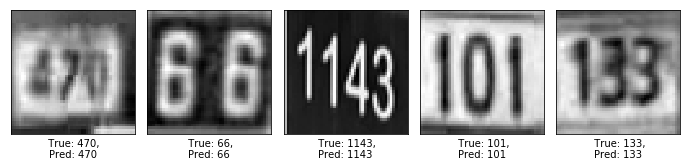

In [10]:
images = extra_dataset[rand_list,:,:,:]

fig, axes = plt.subplots(1,5,figsize=(12, 6))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

for i, ax in enumerate(axes.flat):
    ax.imshow(images[i].reshape(48, 48), cmap='binary')
    ax.set_xticks([])
    ax.set_yticks([])
    xlabel = "  True: {0}, \nPred: {1}".format(cls_true[i], cls_pred[i])
    ax.set_xlabel(xlabel)
    
plt.savefig('../images/svhn_sample_pred_results.png')